In [2]:
using GLM
using CSV
using Optim
using Random
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatsFuns
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmoothedImportanceSampling
using Logging
using ProgressBars

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 7.1 The problem with parameters

Code 7.1

In [3]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = DataFrame(:species => sppnames, :brain => brainvolcc, :mass => masskg);

Code 7.2

In [4]:
d[!,:mass_std] = (d.mass .- mean(d.mass))./std(d.mass)
d[!,:brain_std] = d.brain ./ maximum(d.brain);

Code 7.3

To match results from the book, the model was optimized using MAP estimation, not the MCMC I used before.
The reason for that is the MCMC producing different estimation for log_σ value, which makes all the values 
very different. 

If you want, you can experiment with NUTS sampler for models in 7.1 and 7.2.

In addition, you can also check this discussion: https://github.com/StatisticalRethinkingJulia/StatisticalRethinkingTuring.jl/issues/7

In [5]:
# TODO: move into Rethinking package
using Dates
import StatsBase: sample
import Turing: ModeResult
import LinearAlgebra: Symmetric

function sample(m::ModeResult, n::Int)::Chains
    st = now()
    μ = coef(m)
    Σ = Symmetric(vcov(m))
    dist = MvNormal(μ, Σ)
    Chains(rand(dist, n)', coefnames(m), info=(start_time=st, stop_time=now()))
end

sample (generic function with 49 methods)

In [6]:
Random.seed!(1)

@model function model_m7_1(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ Normal(0, 10)
    μ = @. a + b*mass_std
    log_σ ~ Normal(0, 1)
    brain_std ~ MvNormal(μ, exp(log_σ))
end

estim = optimize(model_m7_1(d.mass_std, d.brain_std), MAP())
m7_1 = DataFrame(sample(estim, 1000))
precis(m7_1)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std    5.5%      50%    94.5%     histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │   0.527  0.0724  0.4097   0.5279   0.6367   ▁▁▁▄▆█▇▄▁▁▁ │
│     b │   0.166  0.0746  0.0473   0.1701    0.283  ▁▁▂▅▆█▆▃▁▁▁▁ │
│ log_σ │ -1.7003  0.2985  -2.213  -1.6961  -1.2384    ▁▂▃▆██▃▂▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


Code 7.4

In [7]:
X = hcat(ones(length(d.mass_std)), d.mass_std)
m = lm(X, d.brain_std)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
───────────────────────────────────────────────────────────────
       Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────
x1  0.528677   0.0705692  7.49    0.0007   0.347273    0.710081
x2  0.167118   0.0762235  2.19    0.0798  -0.0288204   0.363057
───────────────────────────────────────────────────────────────


Code 7.5

In [8]:
Random.seed!(12)

s = simulate(m7_1, (r, x) -> Normal(r.a + r.b * x, exp(r.log_σ)), d.mass_std)
s = vcat(s'...);

r = mean.(eachcol(s)) .- d.brain_std;
resid_var = var(r, corrected=false)
outcome_var = var(d.brain_std, corrected=false)
1 - resid_var/outcome_var

0.4865953626088303

Code 7.6

In [9]:
# function is implemented in a generic way to support any amount of b[x] coefficients
function R2_is_bad(df; sigma=missing)
    degree = ncol(df[!,r"b"])
    # build mass_std*degree matrix, with each col exponentiated to col's index
    t = repeat(d.mass_std, 1, degree)
    t = hcat(map(.^, eachcol(t), 1:degree)...)
    s = [
        begin
            # calculate product on coefficient's vector
            b = collect(r[r"b"])
            μ = r.a .+ t * b
            s = ismissing(sigma) ? exp(r.log_σ) : sigma
            rand(MvNormal(μ, s))
        end
        for r ∈ eachrow(df)
    ]
    s = vcat(s'...);

    r = mean.(eachcol(s)) .- d.brain_std;
    v1 = var(r, corrected=false)
    v2 = var(d.brain_std, corrected=false)
    1 - v1 / v2
end

R2_is_bad (generic function with 1 method)

Code 7.7

In [10]:
Random.seed!(1)

@model function model_m7_2(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ MvNormal([0, 0], 10)
    μ = @. a + b[1]*mass_std + b[2]*mass_std^2
    log_σ ~ Normal(0, 1)
    brain_std ~ MvNormal(μ, exp(log_σ))
end

estim = optimize(model_m7_2(d.mass_std, d.brain_std), MAP())
m7_2 = DataFrame(sample(estim, 1000));

Code 7.8

Implemented the sample in a general way

In [11]:
Random.seed!(1)

@model function model_m7_n(mass_std, brain_std; degree::Int)
    a ~ Normal(0.5, 1)
    b ~ MvNormal(zeros(degree), 10)
    # build matrix n*degree
    t = repeat(mass_std, 1, degree)
    # exponent its columns
    t = hcat(map(.^, eachcol(t), 1:degree)...)
    # calculate product on coefficient's vector
    μ = a .+ t * b
    
    log_σ ~ Normal(0, 1)
    brain_std ~ MvNormal(μ, exp(log_σ))
end

estim = optimize(model_m7_n(d.mass_std, d.brain_std, degree=3), MAP())
m7_3 = DataFrame(sample(estim, 1000));
estim = optimize(model_m7_n(d.mass_std, d.brain_std, degree=4), MAP())
m7_4 = DataFrame(sample(estim, 1000));
estim = optimize(model_m7_n(d.mass_std, d.brain_std, degree=5), MAP())
m7_5 = DataFrame(sample(estim, 1000));

Code 7.9

In [12]:
Random.seed!(2)

@model function model_m7_6(mass_std, brain_std)
    a ~ Normal(0.5, 1)
    b ~ MvNormal(zeros(6), 10)
    μ = @. a + b[1]*mass_std + b[2]*mass_std^2 + b[3]*mass_std^3 + 
               b[4]*mass_std^4 + b[5]*mass_std^5 + b[6]*mass_std^6 
    brain_std ~ MvNormal(μ, 0.001)
end

estim = optimize(model_m7_6(d.mass_std, d.brain_std), MAP())
m7_6 = DataFrame(sample(estim, 1000));

Code 7.10

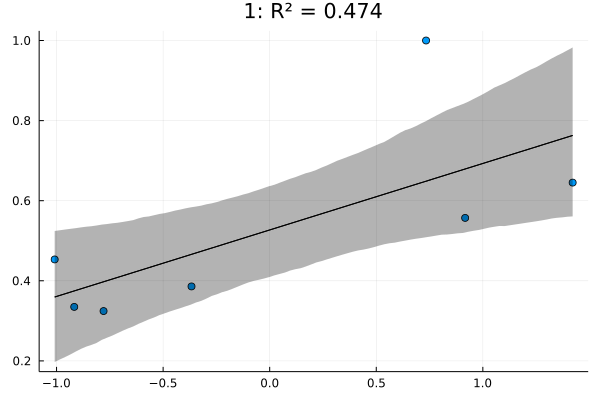

In [13]:
mass_seq = range(extrema(d.mass_std)...; length=100)
l = [
    @. r.a + r.b * mass_seq
    for r ∈ eachrow(m7_1)
]
l = vcat(l'...)
μ = mean.(eachcol(l))
ci = PI.(eachcol(l))
ci = vcat(ci'...)

scatter(d.mass_std, d.brain_std; title="1: R² = $(round(R2_is_bad(m7_1); digits=3))")
plot!(mass_seq, [μ μ]; fillrange=ci, c=:black, fillalpha=0.3)

In [14]:
# reimplemented the brand_plot function to check my results
function brain_plot(df; sigma=missing)
    degree = ncol(df[!,r"b"])
    # build mass_seq*degree matrix, with each col exponentiated to col's index
    t = repeat(mass_seq, 1, degree)
    t = hcat(map(.^, eachcol(t), 1:degree)...)
    l = [
        r.a .+ t * collect(r[r"b"])
        for r ∈ eachrow(df)
    ]
    l = vcat(l'...)
    μ = mean.(eachcol(l))
    ci = PI.(eachcol(l))
    ci = vcat(ci'...)

    r2 = round(R2_is_bad(df, sigma=sigma); digits=3)
    scatter(d.mass_std, d.brain_std; title="$degree: R² = $r2")
    plot!(mass_seq, [μ μ]; fillrange=ci, c=:black, fillalpha=0.3)
end

brain_plot (generic function with 1 method)

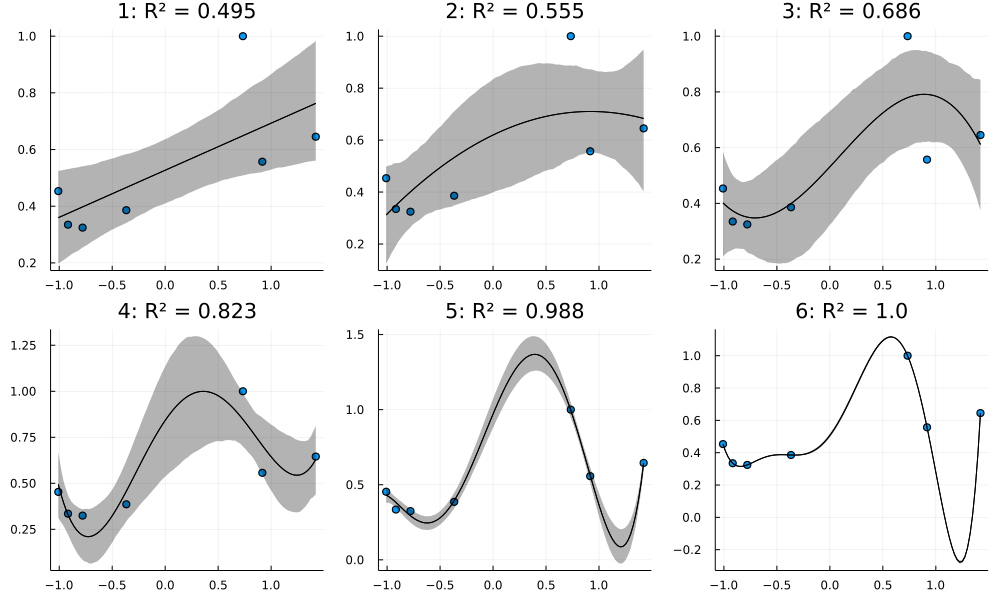

In [15]:
plot(
    brain_plot(m7_1),
    brain_plot(m7_2),
    brain_plot(m7_3),
    brain_plot(m7_4),
    brain_plot(m7_5),
    brain_plot(m7_6, sigma=0.001);
    size=(1000, 600)
)

Code 7.11

In [16]:
i = 3
d_minus_i = d[setdiff(1:end,i),:];

In [17]:
function brain_loo_plot(model, data; title::String)
    (a, b) = extrema(data.brain_std)
    p = scatter(data.mass_std, data.brain_std; title=title, ylim=(a-0.1, b+0.1))
    mass_seq = range(extrema(data.mass_std)...; length=100)
    
    for i ∈ 1:nrow(data)
        d_minus_i = data[setdiff(1:end,i),:]
        df = DataFrame(sample(model(d_minus_i.mass_std, d_minus_i.brain_std), NUTS(), 1000))

        degree = ncol(df[!,r"b"])
        # build mass_seq*degree matrix, with each col exponentiated to col's index
        t = repeat(mass_seq, 1, degree)
        t = hcat(map(.^, eachcol(t), 1:degree)...)
        l = [
            r.a .+ t * collect(r[r"b"])
            for r ∈ eachrow(df)
        ]
        l = vcat(l'...)
        μ = mean.(eachcol(l))
        plot!(mass_seq, μ; c=:black)
    end
    p
end

brain_loo_plot (generic function with 1 method)

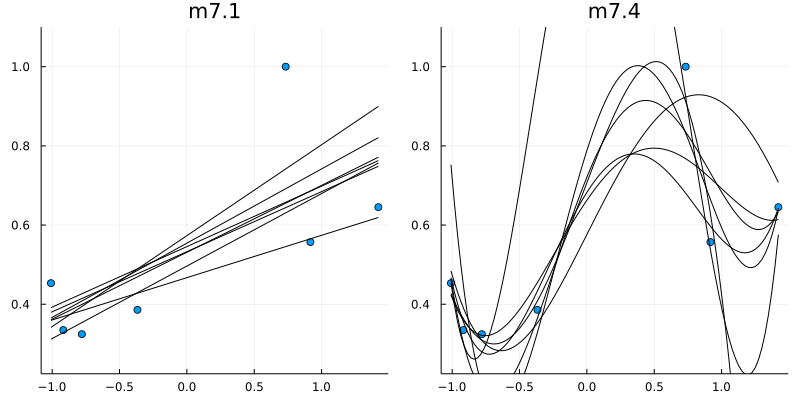

In [18]:
Random.seed!(1)

model_m7_4 = (mass, brain) -> model_m7_n(mass, brain, degree=4)

plot(
    brain_loo_plot(model_m7_1, d, title="m7.1"),
    brain_loo_plot(model_m7_4, d, title="m7.4");
    size=(800, 400)
)

# 7.2 Entropy and accuracy

Code 7.12

In [19]:
p = [0.3, 0.7]
-sum(p .* log.(p))

0.6108643020548935

Code 7.13

In [20]:
lppd(m7_1, (r,x)->Normal(r.a + r.b*x, exp(r.log_σ)), d.mass_std, d.brain_std)

7-element Vector{Float64}:
  0.6083230644962487
  0.6459176597910457
  0.5376029134866727
  0.6202304964969443
  0.4669708249285982
  0.43028792750436295
 -0.8316062108529065

Code 7.14

In [21]:
[
    begin
        s = [
            logpdf(Normal(r.a + r.b * x, exp(r.log_σ)), y)
            for r ∈ eachrow(m7_1)
        ]
        logsumexp(s) - log(length(s))
    end
    for (x, y) ∈ zip(d.mass_std, d.brain_std)
]

7-element Vector{Float64}:
  0.6083230644962487
  0.6459176597910457
  0.5376029134866727
  0.6202304964969443
  0.4669708249285982
  0.43028792750436295
 -0.8316062108529065

Code 7.15

In [22]:
# it could be implemented in a generic way, but I'm too lazy
df_funcs = [
    (m7_1, (r, x) -> Normal(r.a + r.b*x, exp(r.log_σ))),
    (m7_2, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2, exp(r.log_σ))),
    (m7_3, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3, exp(r.log_σ))),
    (m7_4, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3 + 
                                  r."b[4]"*x^4, exp(r.log_σ))),
    (m7_5, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3 + 
                                  r."b[4]"*x^4 + r."b[5]"*x^5, exp(r.log_σ))),
    (m7_6, (r, x) -> Normal(r.a + r."b[1]" * x + r."b[2]"*x^2 + r."b[3]"*x^3 + 
                                  r."b[4]"*x^4 + r."b[5]"*x^5 + r."b[6]"*x^6, 0.001)),
];

In [23]:
[
    sum(lppd(df, f, d.mass_std, d.brain_std))
    for (df, f) ∈ df_funcs
]

6-element Vector{Float64}:
  2.477726675850966
  2.6399363127557827
  3.6335767479005687
  5.307175447338964
 14.062054177044383
 39.516877683409476

Code 7.16

In [24]:
@model function m7_sim(x, y; degree::Int=2)
    beta ~ MvNormal(zeros(degree), 1)
    μ = x * beta
    y ~ MvNormal(μ, 1)
end

# Calculate lppd*(-2) from sampled params (b), x matrix and target y values
function get_lppd(m_df, xseq, yseq)
    t = DataFrame(:b => collect(eachrow(Matrix(m_df))))
    -2*sum(lppd(t, (r, x) -> Normal(r.b'*x, 1), eachrow(xseq), yseq))
end

function calc_train_test(N, k; count=100)
    trn_v, tst_v = [], []
    for _ in 1:count
        # method sim_train_test from StatisticalRethinking just simulates the data to be fitted by the model
        y, x_train, x_test = sim_train_test(N=N, K=k)

        estim = optimize(m7_sim(x_train, y, degree=max(2,k)), MAP())
        m7_2 = DataFrame(sample(estim, 1000))
        # commented out is the MCMC way of estimation instead of MAP
#         m_chain = sample(m7_sim(x_train, y, degree=max(2,k)), NUTS(), 1000)
#         m7_2 = DataFrame(m_chain)
        t1 = get_lppd(m7_2, x_train, y)
        t2 = get_lppd(m7_2, x_test, y)
        push!(trn_v, t1)
        push!(tst_v, t2)
    end
    (mean_and_std(trn_v), mean_and_std(tst_v))
end

calc_train_test (generic function with 1 method)

Code 7.17

In [25]:
k_count = 5
k_seq = 1:k_count
count = 100
trn_20, tst_20 = [], []
trn_100, tst_100 = [], []

Threads.@threads for k in k_seq
    println("Processing $k with N=20...")
    t1, t2 = calc_train_test(20, k, count=count)
    push!(trn_20, t1)
    push!(tst_20, t2)
    println("Processing $k with N=100...")
    t1, t2 = calc_train_test(100, k, count=count)
    push!(trn_100, t1)
    push!(tst_100, t2)
end

Processing 1 with N=20...
Processing 1 with N=100...
Processing 2 with N=20...
Processing 2 with N=100...
Processing 3 with N=20...
Processing 3 with N=100...
Processing 4 with N=20...
Processing 4 with N=100...
Processing 5 with N=20...
Processing 5 with N=100...


Code 7.18

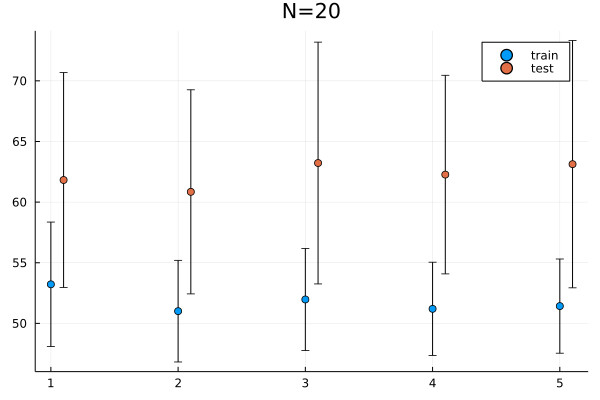

In [26]:
scatter(k_seq, first.(trn_20); yerr=last.(trn_20), label="train", title="N=20")
scatter!(k_seq .+ .1, first.(tst_20); yerr=last.(tst_20), label="test")

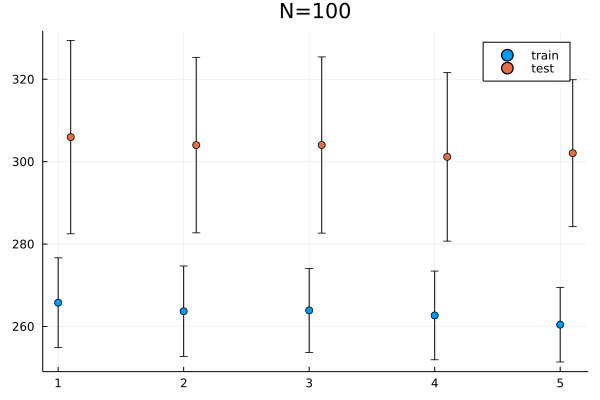

In [27]:
scatter(k_seq, first.(trn_100); yerr=last.(trn_100), label="train", title="N=100")
scatter!(k_seq .+ .1, first.(tst_100); yerr=last.(tst_100), label="test")

Hm, something is different

# 7.3 Golem taming: regularization

No code pieces in this section

# 7.4 Predicting predictive accuracy

Code 7.19

In [28]:
d = DataFrame(CSV.File("data/cars.csv", drop=["Column1"]))

@model function model_m(speed, dist)
    a ~ Normal(0, 100)
    b ~ Normal(0, 10)
    μ = @. a + b * speed 
    σ ~ Exponential(1)
    dist ~ MvNormal(μ, σ)
end

Random.seed!(17)
m_ch = sample(model_m(d.speed, d.dist), NUTS(), 1000)
m_df = DataFrame(m_ch);

Code 7.20

In [29]:
fun = (r, (x, y)) -> normlogpdf(r.a + r.b * x, r.σ, y)
lp = link(m_df, fun, zip(d.speed, d.dist))
lp = hcat(lp...);

Code 7.21

In [30]:
n_samples, n_cases = size(lp)
lppd_vals = [
    logsumexp(c) - log(n_samples)
    for c in eachcol(lp)
];

## if only lppd were needed, we can calculate it with
# lppd_vals = lppd(m_df, (r, x) -> Normal(r.a + r.b * x, r.σ), d.speed, d.dist)

Code 7.22

In [31]:
pWAIC = [
    StatisticalRethinking.var2(c)
    for c in eachcol(lp)
];

Code 7.23

In [32]:
-2*(sum(lppd_vals) - sum(pWAIC))

420.43515417392257

Code 7.24

In [33]:
waic_vec = -2*(lppd_vals .- pWAIC)
sqrt(n_cases * StatisticalRethinking.var2(waic_vec))

15.828915070188636

# 7.5 Model comparison

Data and models from chapter 6

In [34]:
Random.seed!(70)
# number of plants
N = 100
h0 = rand(Normal(10, 2), N)
treatment = repeat(0:1, inner=div(N, 2))
fungus = [rand(Binomial(1, 0.5 - treat*0.4)) for treat in treatment]
h1 = h0 .+ rand(MvNormal(5 .- 3 .* fungus, 1))

d = DataFrame(:h0 => h0, :h1 => h1, :treatment => treatment, :fungus => fungus)

@model function model_m6_6(h0, h1)
    p ~ LogNormal(0, 0.25)
    σ ~ Exponential(1)
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_6 = sample(model_m6_6(d.h0, d.h1), NUTS(), 1000)
m6_6_df = DataFrame(m6_6)

@model function model_m6_7(h0, treatment, fungus, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    bf ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment + bf*fungus
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_7 = sample(model_m6_7(d.h0, d.treatment, d.fungus, d.h1), NUTS(), 1000)
m6_7_df = DataFrame(m6_7)

@model function model_m6_8(h0, treatment, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_8 = sample(model_m6_8(d.h0, d.treatment, d.h1), NUTS(), 1000)
m6_8_df = DataFrame(m6_8);

Code 7.25

In [35]:
fun = (r, (x,bt,bf,y)) -> normlogpdf(x*(r.a + r.bt*bt + r.bf*bf), r.σ, y)

# log likelihood calculation
ll = link(m6_7_df, fun, zip(d.h0, d.treatment, d.fungus, d.h1));
ll = hcat(ll...);

waic(ll)

(WAIC = 325.58200753081104, lppd = -159.04241183268823, penalty = 3.748591932717315, std_err = 13.2307246477045)

Code 7.26

In [36]:
fun = (r, (x,y)) -> normlogpdf(x*r.p, r.σ, y)
m6_ll = link(m6_6_df, fun, zip(d.h0, d.h1));
m6_ll = hcat(m6_ll...);

fun = (r, (x,bt,bf,y)) -> normlogpdf(x*(r.a + r.bt*bt + r.bf*bf), r.σ, y)
m7_ll = link(m6_7_df, fun, zip(d.h0, d.treatment, d.fungus, d.h1));
m7_ll = hcat(m7_ll...);

fun = (r, (x,bt,y)) -> normlogpdf(x*(r.a + r.bt*bt), r.σ, y)
m8_ll = link(m6_8_df, fun, zip(d.h0, d.treatment, d.h1));
m8_ll = hcat(m8_ll...);

compare([m6_ll, m7_ll, m8_ll], :waic, mnames=["m6", "m7", "m8"])

,models,WAIC,lppd,SE,dWAIC,dSE,pWAIC,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m7,325.6,318.08,13.23,0.0,0.0,3.75,1.0
2,m8,397.9,392.35,13.07,72.3,13.1,2.79,0.0
3,m6,407.4,404.16,12.04,81.8,12.48,1.61,0.0


Code 7.27

In [37]:
waic_m6_7 = waic(m7_ll, pointwise=true).WAIC
waic_m6_8 = waic(m8_ll, pointwise=true).WAIC
n = length(waic_m6_7)
diff_m6_78 = waic_m6_7 - waic_m6_8
sqrt(n*StatisticalRethinking.var2(diff_m6_78))

13.033371228252397

Code 7.28

In [38]:
 40.0 .+ [-1, 1]*10.4*2.6

2-element Vector{Float64}:
 12.959999999999997
 67.04

Code 7.29

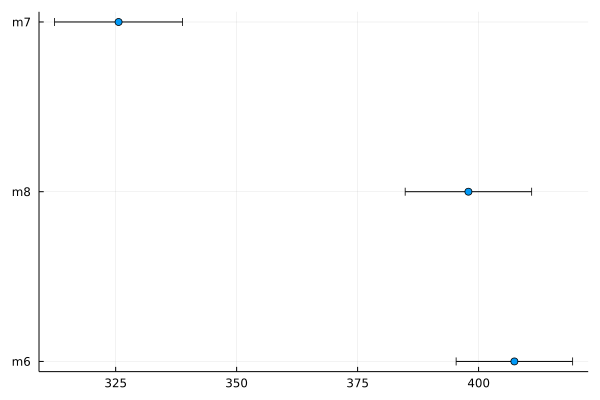

In [39]:
dw = compare([m6_ll, m7_ll, m8_ll], :waic, mnames=["m6", "m7", "m8"])
scatter(reverse(dw.WAIC), reverse(dw.models); xerror=reverse(dw.SE))

Code 7.30

In [40]:
waic_m6_6 = waic(m6_ll, pointwise=true).WAIC
waic_m6_8 = waic(m8_ll, pointwise=true).WAIC
diff_m6_68 = waic_m6_6 - waic_m6_8
sqrt(n*StatisticalRethinking.var2(diff_m6_68))

6.966887253196819

Code 7.31

Current version of `StatisticalRethinking.compare` doesn't calculate pairwise error. You should use above logic to get values not returned in `compare` result.

Code 7.32

In [41]:
Random.seed!(1)
d = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:M] = standardize(ZScoreTransform, d.Marriage)
d[!,:A] = standardize(ZScoreTransform, d.MedianAgeMarriage)

@model function model_m5_1(A, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    μ = @. a + bA * A
    D ~ MvNormal(μ, σ)
end

m5_1 = sample(model_m5_1(d.A, d.D), NUTS(), 1000)
m5_1_df = DataFrame(m5_1)

@model function model_m5_2(M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    μ = @. a + bM * M
    D ~ MvNormal(μ, σ)
end

m5_2 = sample(model_m5_2(d.M, d.D), NUTS(), 1000)
m5_2_df = DataFrame(m5_2);

@model function model_m5_3(A, M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
end

m5_3 = sample(model_m5_3(d.A, d.M, d.D), NUTS(), 1000)
m5_3_df = DataFrame(m5_3);

In [42]:
fun = (r, (x,y)) -> normlogpdf(r.a + r.bA * x, r.σ, y)
m5_1_ll = link(m5_1_df, fun, zip(d.A, d.D));
m5_1_ll = hcat(m5_1_ll...)

fun = (r, (x,y)) -> normlogpdf(r.a + r.bM * x, r.σ, y)
m5_2_ll = link(m5_2_df, fun, zip(d.M, d.D));
m5_2_ll = hcat(m5_2_ll...)

fun = (r, (a,m,y)) -> normlogpdf(r.a + r.bA * a + r.bM * m, r.σ, y)
m5_3_ll = link(m5_3_df, fun, zip(d.A, d.M, d.D));
m5_3_ll = hcat(m5_3_ll...);

Code 7.33

In [43]:
compare([m5_1_ll, m5_2_ll, m5_3_ll], :psis, mnames=["m5.1", "m5.2", "m5.3"])

,models,PSIS,lppd,SE,dPSIS,dSE,pPSIS,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m5.1,125.2,118.45,12.4,0.0,0.0,3.65,0.67
2,m5.3,126.6,118.12,12.33,1.4,0.82,4.56,0.33
3,m5.2,139.0,133.43,9.59,13.8,8.9,3.05,0.0


Code 7.34

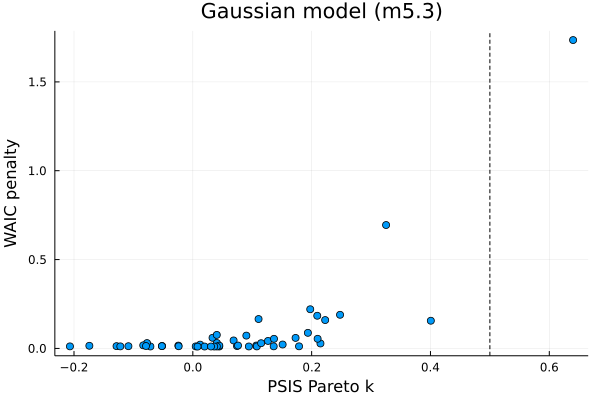

In [44]:
using ParetoSmooth

# reshape data to format of psis_loo function
function ll_to_psis(ll)
    t = ll'
    collect(reshape(t, size(t)..., 1))
end

m5_3_t = ll_to_psis(m5_3_ll)
PSIS_m5_3 = psis_loo(m5_3_t)
WAIC_m5_3 = waic(m5_3_ll, pointwise=true)

scatter(PSIS_m5_3.pointwise(:pareto_k), WAIC_m5_3.penalty, 
    xlab="PSIS Pareto k", ylab="WAIC penalty", title="Gaussian model (m5.3)")
vline!([0.5], c=:black, s=:dash)

Code 7.35

In [45]:
# have to import it explicitly, as it is not exported
import Distributions: IsoTDist

@model function model_m5_3t(A, M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ IsoTDist(2, μ, σ)
end

m5_3t = sample(model_m5_3t(d.A, d.M, d.D), NUTS(), 1000)
m5_3t_df = DataFrame(m5_3);

Visualize PSIS

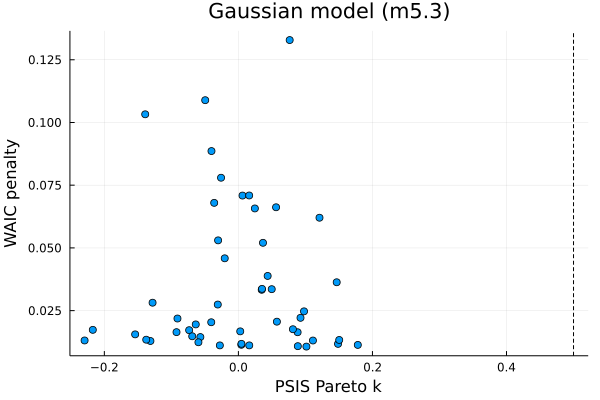

In [46]:
fun = (r, (a,m,y)) -> logpdf(IsoTDist(2, [r.a + r.bA * a + r.bM * m], r.σ), [y])
m5_3t_ll = link(m5_3t_df, fun, zip(d.A, d.M, d.D));
m5_3t_ll = hcat(m5_3t_ll...);

m5_3t_t = ll_to_psis(m5_3t_ll)
PSIS_m5_3t = psis_loo(m5_3t_t)
WAIC_m5_3t = waic(m5_3t_ll, pointwise=true)

scatter(PSIS_m5_3t.pointwise(:pareto_k), WAIC_m5_3t.penalty, 
    xlab="PSIS Pareto k", ylab="WAIC penalty", title="Gaussian model (m5.3)")
vline!([0.5], c=:black, s=:dash)